In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import missingno as msno
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

## Data Analysis and Visualization

In [3]:
def plotImg(data, label, gridX, gridY, size = 5):
    plt.figure(figsize=(size,size))
    for i in range(gridX*gridY):
        plt.subplot(gridX, gridY, i+1)
        plt.imshow(data[i].reshape(28,28), cmap = 'gray')
        plt.title(f'Class Digit: {label[i]}', fontsize = 8, fontweight='bold')

In [4]:
def data_analysis(x_train, x_test, y_train):
    print('Displaying count plots for each class:')
    sns.countplot(x = y_train)
    plt.show()
    print('Checking for any null entries')
    print(f'The number of missing values in the train feature dataset is: {x_train.isna().any().sum()}')
    print(f'The number of missing values in the test feature dataset is: {x_test.isna().any().sum()}')
    
    temp_num = 7
    print(f'\nDisplaying first {temp_num} classes and their labels:')
    plotImg(x_train.values, y_train.values, 1, temp_num, size = 10)
    

## Data Preparation

In [5]:
def data_prep(x_train, x_test, y_train, testSize = 0.3):
    # Reshaping into desired format (28x28)
    x_train = x_train.values.reshape(-1, 28, 28, 1)
    x_test = x_test.values.reshape(-1,28,28,1)
    x_test = x_test/255.
    
    # Converting class vector into binary class matrix
    y_train = to_categorical(y_train, num_classes = num_classes)
    
    # Train with 70/30 train/test split
    imgAug = ImageDataGenerator(validation_split = testSize, rescale = 1./255, rotation_range = 30, zoom_range = 0.03)
    train_itr = imgAug.flow(x_train, y_train, batch_size = 50, subset='training')
    validation_itr = imgAug.flow(x_train, y_train, batch_size = 50, subset='validation')
    
    return train_itr, validation_itr, x_test

## Modeling

In [7]:
def create_cnn_model(train_itr, val_itr, batch = 50, epochs = 40):
    # Create callback to allow earlystopping
    callback = callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.001, patience = 5, 
                                   restore_best_weights = True, verbose = 0)
    
    # Build a sequential CNN model (parameter defining)
    cnn = Sequential([
        Conv2D(filters = 16, kernel_size = 5, padding = 'same', activation = 'relu', input_shape = (28,28,1)),
        MaxPool2D(pool_size = 2),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = 5, padding = 'same', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        BatchNormalization(),
        Flatten(),
        Dense(units = 256, activation = 'relu'),
        Dropout(0.4),
        Dense(num_classes, activation = 'softmax')
    ])
    cnn.summary()
    
    # Complining the pre-defined model
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cb = cnn.fit(
        train_itr,
        validation_data = val_itr,
        batch_size = batch,
        epochs = epochs,
        callbacks = [callback]
    )
    
    return cnn, cb

In [21]:
def eval_model(model, tr_model, x_test, test_df):
    # Plot loss and accuracy of training vs. validation set to evaluate the performance of the model
    df_hist = pd.DataFrame(tr_model.history)
    df_hist.loc[:, ['loss', 'val_loss']].plot()
    df_hist.loc[:, ['accuracy', 'val_accuracy']].plot()
    
    # Prediction
    print('Starting the prediction')
    y_pred = model.predict(x_test)
    
    # Creating output in a dataframe
    out_df = test_df.copy()
    out_df['Label'] = np.argmax(y_pred, axis = 1)
    out_df['ImageId'] = out_df.index + 1
    
    return out_df
  
    

In [22]:
def main():
    # Load both train and test data
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    # Define number of unique classes (Digits)
    global num_classes
    num_classes = len(np.unique(train_df['label']))
    
    Y_train = train_df["label"]
    X_train = train_df.drop(labels = ["label"],axis = 1) 

    # Free up some space
    del train_df 
    
    data_analysis(X_train, test_df, Y_train)
    
    train_itr, validation_itr, x_test = data_prep(X_train, test_df, Y_train)
    cnn, cb = create_cnn_model(train_itr, validation_itr)
    out_df = eval_model(cnn, cb, x_test, test_df)
    
    pred_X = out_df.iloc[:,:-2].values
    pred_Y = out_df['Label'].values
    
    print('Displaying first 14 true classes and their predicted label:')
    plotImg(pred_X, pred_Y, 2, 7, size = 10)
    plt.show()

Displaying count plots for each class:


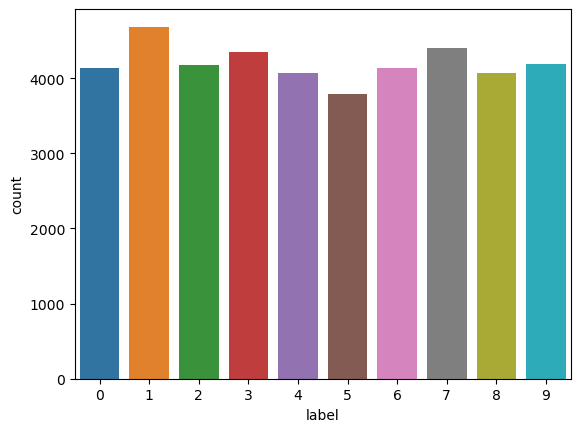

Checking for any null entries
The number of missing values in the train feature dataset is: 0
The number of missing values in the test feature dataset is: 0

Displaying first 7 classes and their labels:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        12832     
                                                 

In [ ]:
if __name__ == '__main__':
    main()